In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

from utils.complex import ComplexTuple
%load_ext autoreload
%autoreload 2

In [95]:
from tasks.mnist.generate_scenes import make_one
from properties import Color
from tasks.mnist.parameters import D_table
from glimpse import accumulate_glimpses

In [51]:
scene, glimpses, glimpse_xy, _, _, _ = make_one()

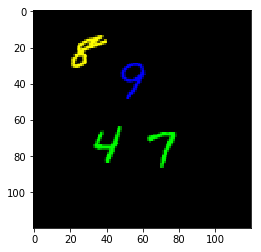

In [52]:
plt.imshow(scene.img.astype(np.uint8))
plt.show()

In [53]:
from network import glimpse_features, glimpse_network_output
from train_queries import L, S0
from tasks.mnist.query_scene import _direction_keys
import config
from visualize import raster, X

In [54]:
predict = theano.function(
        inputs=[glimpse_features],   # _ x N dimensional matrix
        outputs=glimpse_network_output,
        allow_input_downcast=True)

dir_lookup = dict((v, k) for k, v in _direction_keys.items())


In [55]:
scene, glimpses, glimpse_xy, sample_xy, digit_labels, color_labels = make_one()
glimpses = glimpses / 255.0

S = S0.get_value()
nnnn = config.GLIMPSES - 3
for i in range(config.GLIMPSES - 3):
    g = ComplexTuple(*predict(glimpses[i][None]))
    S = (S + g * L.encode_numeric(config.POS_SCALE(glimpse_xy[i]))).reshape((1024,))

for i in range(3):
    g = ComplexTuple(*predict(glimpses[nnnn + i][None]))
    S = (S + g * L.encode_numeric(config.POS_SCALE(glimpse_xy[nnnn + i]))).reshape((1024,))

In [56]:
D_digits = D_table["Digits"].get_value()
D_colors = D_table["Color"].get_value()
digit_belief = raster(D_digits.real, D_digits.imag, S.real, S.imag)
color_belief = raster(D_colors.real, D_colors.imag, S.real, S.imag)

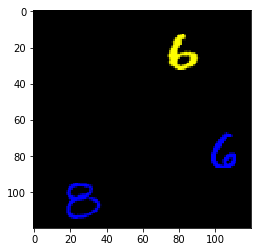

In [60]:
plt.imshow(scene.img.astype(np.uint8))
plt.show()

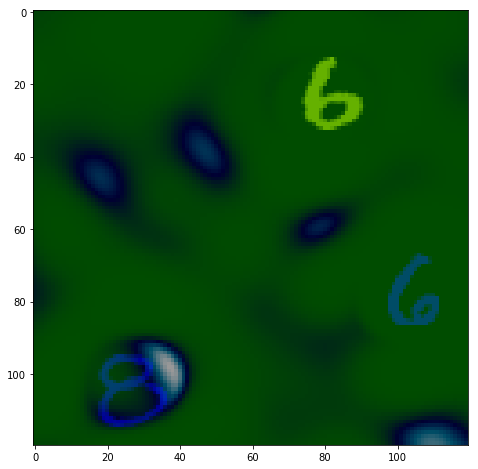

In [61]:
plt.figure(figsize=(8, 8))
plt.imshow(scene.img.astype(np.uint8))
plt.imshow(digit_belief[:, :, 3], alpha=0.6, cmap="ocean")
plt.show()

Okay now that S represents the scene, we can see what happens when we query for the location of stuff.

In [96]:
# where is the 8?
def where_is(digit=None, color=None):
    if not digit and not color:
        raise Exception("Need at least one of digit or color")
    v_d = D_digits.get_columns(digit) if digit is not None else 0
    v_c = D_colors.get_columns(Color.params.index(color)) if color is not None else 0
    v = v_d + v_c
    
    X_arr = X.get_value()
    where_is = X_arr.dot(v.conj * S).real
    plt.imshow(where_is, vmin=0, vmax=10)
    plt.colorbar()
    plt.show()

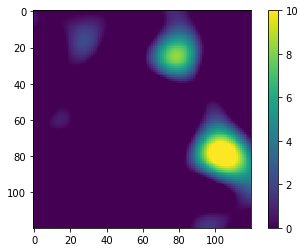

In [100]:
where_is(6, "red")